In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import scipy.ndimage as nd
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.metrics import accuracy_score
from skimage.feature import local_binary_pattern
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import IncrementalPCA
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torchvision.models as models
import os

In [ ]:

def get_cifar10_dataloaders(val_percentage=0.1, batch_size=20):
  input_size = 224

  transform_test = transforms.Compose(
    [transforms.Resize(input_size),
     transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
  
  transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                        #transforms.RandomVerticalFlip(),
                        transforms.RandomRotation(5),
                        transforms.RandomRotation(7),
                        transforms.Resize(input_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ])

  dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train) #len=50000

  dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test) #len=10000

  len_train = int(len(dataset) * (1.-val_percentage))
  len_val = len(dataset) - len_train

  dataset_train, dataset_val = random_split(dataset, [len_train, len_val])

  data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=2)

  data_loader_val   = DataLoader(dataset_val, batch_size=batch_size,shuffle=True,num_workers=2)

  data_loader_test  = DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=2)

  return data_loader_train, data_loader_val, data_loader_test

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# _ = get_cifar10_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


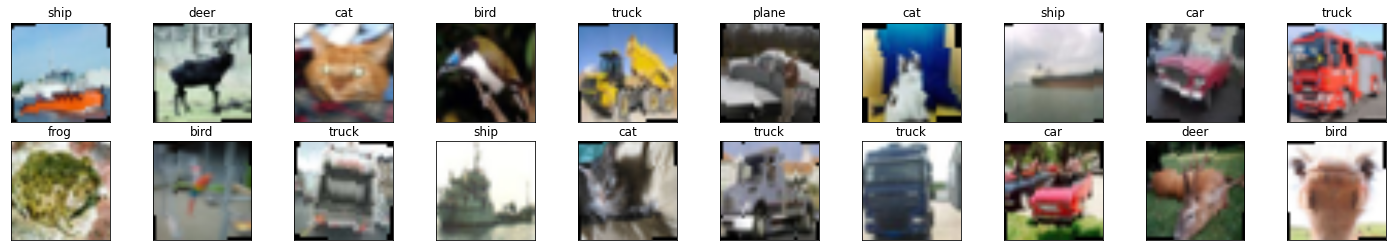

In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image / 2 + 0.5     # unnormalize
  image = image.transpose(1, 2, 0)
  # print(image.shape)
  # image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  # image = image.clip(0, 1)
  return image

a,_,_=get_cifar10_dataloaders( batch_size=20)
dataiter = iter(a)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
class Experiment:

    def __init__(self,model=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.use_cuda = torch.cuda.is_available()
        self.model = model.cuda()
        self.optimizer = None
        self.scheduler = None
        

        self.criterion = torch.nn.CrossEntropyLoss().cuda() if self.use_cuda else torch.nn.MSELoss()
        self.train_losses = []
        self.train_accs = []
        self.train_f1_log = []
        self.val_losses = []
        self.val_accs = []
        self.val_f1_log = []
        self.start_epoch = 1

    def train(self,train_data_loader,
              val_data_loader,
              save_dir,
              model_name,
              num_epochs=75, 
              learning_rate=0.001,
              validate_each_epoch=False,
              verbose=False):
       

        self.model.train()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=1, verbose=True)
        
        best_val_f1 = 0.4

        for epoch in range(self.start_epoch, num_epochs + 1):

            print('Epoch {}/{}'.format(epoch, num_epochs))

            epoch_losses = []
            epoch_accs = []
            epoch_f1 = []
            i = 0
            if verbose :
              pbar = tqdm(train_data_loader)
            else :
              pbar = train_data_loader
            for data in pbar:

                images,labels  = data
                labels = labels.to(self.device)
                images = images.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model.forward(images)

                loss = self.criterion(outputs, labels)
                loss.backward()

                self.optimizer.step()

                epoch_losses.append(loss.data.cpu())
                
                batch_accuracy = accuracy(outputs, labels)

                epoch_accs.append(batch_accuracy) 
                batch_f1 = f1_score_(outputs, labels)
                epoch_f1.append(batch_f1) 

                if verbose:
                  pbar.set_postfix({"Batch loss ":loss.data.cpu().numpy(),' Epoch loss ': np.mean(epoch_losses)," Batch Acc ":batch_accuracy.numpy()," Epoch Acc ":np.mean(epoch_accs),
                                    " Batch f1 ":batch_f1,"  Avg Epoch f1 ":np.mean(epoch_f1)})   

            self.train_losses.append(np.mean(epoch_losses))
            self.train_accs.append(np.mean(epoch_accs))
            self.train_f1_log.append(np.mean(epoch_f1))



            if validate_each_epoch:
                val_loss,val_acc,val_f1= self.validate(val_data_loader)
                self.val_losses.append(val_loss)
                self.val_accs.append(val_acc) 
                self.val_f1_log.append(val_f1) 
                if verbose:  
                  print("Val loss : ",val_loss,' Val Acc : ',val_acc," Val f1 : ",val_f1)   
            
            #Lr scheduler
            self.scheduler.step(np.mean(epoch_losses))


            if val_f1 > best_val_f1 :
              self.save_parameters(model_name+" "+str(val_f1.round(2)), save_dir,epoch)
              best_val_f1 = val_f1




    def validate(self,data_loader):
        
        self.model.eval()
        losses = []
        predictions = []
        y_val = []
        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                labels = labels.to(self.device)
                images = images.to(self.device)

                outputs = self.model.forward(images)
                loss = self.criterion(outputs, labels)
                losses.append(loss.data.cpu())
                _, outputs = torch.max(outputs, dim=1)
                predictions.extend(list(outputs.view(-1).cpu().numpy()))
                y_val.extend(list(labels.view(-1).cpu().numpy()))

        acc = accuracy_score(y_val, predictions)
        f1 = f1_score(y_val, predictions,average='micro')

        self.model.train()
        
        return np.mean(losses),acc,f1




    def predict_loader(self,data_loader):
        self.model.eval()
        predictions = []
        y_true=[]
        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                images = images.to(self.device)
                outputs = self.model.forward(images)
                _, outputs = torch.max(outputs, dim=1)
                predictions.extend(list(outputs.view(-1).cpu().numpy()))
                y_true.extend(list(labels.view(-1).cpu().numpy()))

        self.model.train()
        return predictions,y_true
    






    def feature_extraction(self,data_loader):

        self.model.eval()
        predictions = []

        def hook(module, input, output):
          for i in output:
            predictions.append(i.detach().cpu().view(512).numpy())

        self.model.cnn1.avgpool.register_forward_hook(hook)

        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                images = images.to(self.device)
                outputs = self.model.forward(images)

        self.model.train()
        return predictions





    def save_parameters(self,model_name, directory,epoch):
        """Saves the parameters of the network to the specified directory.

        Parameters
        ----------
        epoch : int
            The current epoch
        directory : str
            The directory to which the parameters will be saved
        """
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, os.path.join(directory, model_name +'.pth'))

    def load_parameters(self, path):
        """Loads the given set of parameters.

        Parameters
        ----------
        path : str
            The file path pointing to the file containing the parameters
        """
        self.optimizer = torch.optim.Adam(self.model.parameters())
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.start_epoch = checkpoint['epoch']

    def plot(self):

      fig, axes = plt.subplots(3, 1, figsize = (10,10))

      train_losses = np.array(self.train_losses)
      val_losses  = np.array(self.val_losses)
      axes[0].plot(train_losses, label = "training loss")
      axes[0].plot(val_losses, label = "val loss")
      axes[0].set_title('loss variation during training', fontsize = 8)
      axes[0].legend()


      train__accs = np.array(self.train_accs)
      val_accs  = np.array(self.val_accs)
      axes[1].plot(train__accs, label = "training accuracy")
      axes[1].plot(val_accs, label = "val accuracy")
      axes[1].set_title('accuracy variation during training', fontsize = 8)
      axes[1].legend()



      train_f1_log = np.array(self.train_f1_log)
      val_f1_log  = np.array(self.val_f1_log)
      axes[2].plot(train_f1_log, label = "training f1 score")
      axes[2].plot(val_f1_log, label = "val f1 score")
      axes[2].set_title('f1 score variation during training', fontsize = 8)
      axes[2].legend()

      plt.show()



      
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


from sklearn.metrics import f1_score,accuracy_score

def f1_score_(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return f1_score(preds.detach().cpu().numpy(), labels.cpu().numpy(), average='micro')

In [ ]:
#https://stackoverflow.com/questions/59452502/pytorch-how-to-derive-manually-resnet
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.rsn = models.resnet18(pretrained=False)
        #change the fully connected layers https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
        #self.fc = nn.Linear(512 * block.expansion, num_classes)<- num_classes=10
        self.rsn.fc = nn.Linear(512, 10)

      
    def forward(self, x):
        out =self.rsn(x)
        return out

In [ ]:
model1= Resnet().cuda() #CNN()
exp_1 = Experiment(model1)

In [ ]:
for param in exp_1.model.parameters():
    param.requires_grad = True

In [ ]:
model1

Resnet(
  (cnn1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
train_loader, validation_loader, test_loader=get_cifar10_dataloaders()
exp_1.train(train_data_loader=train_loader,
                        val_data_loader=validation_loader,
                        save_dir="/content/",
                        model_name = 'model resnet18',
                        num_epochs=10,
                        learning_rate=0.001, 
                        validate_each_epoch=True,
                        verbose=True)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  1.140991  Val Acc :  0.6022  Val f1 :  0.6022
Epoch 2/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.87428266  Val Acc :  0.6864  Val f1 :  0.6864
Epoch 3/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.7939877  Val Acc :  0.7282  Val f1 :  0.7282
Epoch 4/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.6611373  Val Acc :  0.7686  Val f1 :  0.7686
Epoch 5/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.5946487  Val Acc :  0.804  Val f1 :  0.804
Epoch 6/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.63481385  Val Acc :  0.7818  Val f1 :  0.7818
Epoch 7/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.5342732  Val Acc :  0.8166  Val f1 :  0.8166
Epoch 8/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.53345287  Val Acc :  0.8146  Val f1 :  0.8146
Epoch 9/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.46950328  Val Acc :  0.8344  Val f1 :  0.8344
Epoch 10/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.50587636  Val Acc :  0.8316  Val f1 :  0.8316


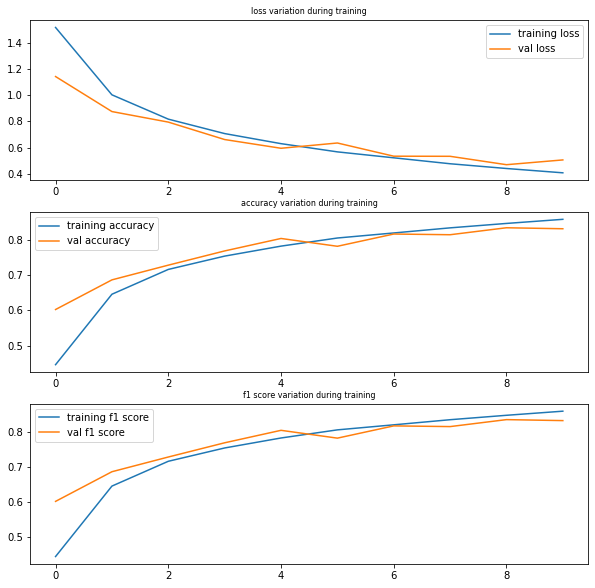

In [ ]:
exp_1.plot()

In [ ]:
#Resnet alone
exp_1.validate(test_loader)

  0%|          | 0/500 [00:00<?, ?it/s]

(0.45528924, 0.8526, 0.8526)

In [ ]:
#Summary
#resnet 11 classes -> test = 0.8565 , valid 10 epochs =0.8462 , 1 epoch valid = 0.6172 (possibily better  but not ok)
#resnet sans fc -> test = 0.8514, valid 10 epoch = 0.8298, valid 1 epoch =  0.562
#resnet 10 fc -> test = 0.8587, valid 10 epoch = 0.8456, valid 1 epoch =  0.5556

  0%|          | 0/500 [00:00<?, ?it/s]

f1 score :  0.8526
              precision    recall  f1-score   support

       plane       0.87      0.82      0.84      1000
         car       0.95      0.89      0.92      1000
        bird       0.84      0.78      0.81      1000
         cat       0.77      0.71      0.74      1000
        deer       0.78      0.91      0.84      1000
         dog       0.83      0.78      0.80      1000
        frog       0.94      0.87      0.90      1000
       horse       0.92      0.88      0.90      1000
        ship       0.89      0.93      0.91      1000
       truck       0.78      0.97      0.86      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



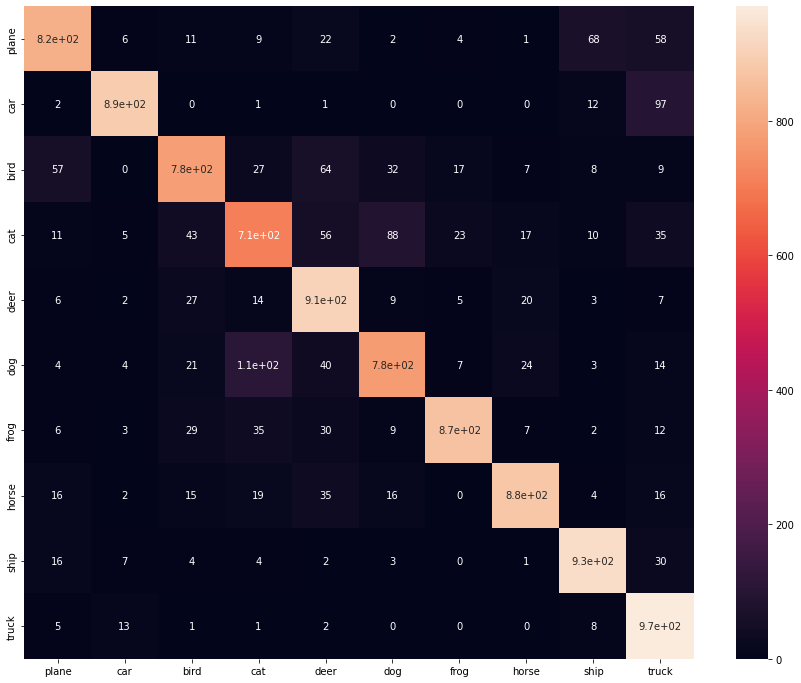

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_val)
y_hat,y_true = exp_1.predict_loader(test_loader)
#y_true = dataset.labels[test_dataset.indices]
print("f1 score : ",f1_score(y_hat,y_true, average='micro'))
print(classification_report(y_true, y_hat,target_names=list(classes)))

M = confusion_matrix(y_true, y_hat)

df_cm = pd.DataFrame(M, index = [i for i in list(classes)],
                      columns = [i for i in list(classes)])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)